In [ ]:
#esto sirve para borrar carpetas
#import shutil
#shutil.rmtree('/content/README.md')

In [ ]:
# esto es para permitir tener acceso a drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# esto es para la ruta del archivo zip, una vez conectado con drive se puede buscar el archivo
# en el explorador de colab darle click derecho y pegar el path
zip_path = '/content/drive/MyDrive/numbers.zip'

# no pongo /content/numbers porque al descomprimir ya crea una carpeta que se llama numbers
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)



In [ ]:
import zipfile

# esto es para la data original
zip_path2 = '/content/drive/MyDrive/img.zip'
extract_path = '/content/img'

with zipfile.ZipFile(zip_path2, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import matplotlib.pyplot as plt
import os
import shutil
from collections import defaultdict
import tensorflow as tf
from tensorflow import keras
import numpy as np
import keras.preprocessing.image as kerasImg
import keras.layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import ops

In [ ]:
def count_files_in_polymnist(source_base_path):
    count_by_m_folder = defaultdict(int)
    count_by_class = defaultdict(int)

    for split in ['train', 'test']:
        split_path = os.path.join(source_base_path, split)
        print(f"\n=== {split.upper()} ===")

        for m_folder in ['m0', 'm1', 'm2', 'm3', 'm4']:
            m_path = os.path.join(split_path, m_folder)
            if not os.path.exists(m_path):
              print(f"folder {m_path} not found")
              continue

            files = [f for f in os.listdir(m_path) if f.endswith('.png')]
            count_by_m_folder[m_folder] = len(files)
            print(f"{m_folder}: {len(files)} archivos")

            for filename in files:
                label = filename.split('.')[-2]
                count_by_class[label] += 1

    return count_by_class

def count_files_in_new_folder(source_base_path):
    count_by_m_folder = defaultdict(int)
    count_by_class = defaultdict(int)

    distribution = {"train":{}, "test":{}}


    for split in ['train', 'test']:
        split_path = os.path.join(source_base_path, split)
        print(f"\n=== {split.upper()} ===")

        for m_folder in range(10):
            m_path = os.path.join(split_path, str(m_folder))
            if not os.path.exists(m_path):
                continue

            files = [f for f in os.listdir(m_path) if f.endswith('.png')]
            count_by_m_folder[m_folder] = len(files)
            print(f"{m_folder}: {len(files)} archivos")
            distribution[split][m_folder] = len(files)

            for filename in files:
                label = filename.split('.')[-2]
                count_by_class[label] += 1

    #print("\n=== RESUMEN POR CLASE ===")
    #for label in sorted(count_by_class.keys()):
    #    print(f"Clase {label}: {count_by_class[label]} imágenes")

    return count_by_class, distribution



In [ ]:
# Rutas
source_base_path = '/content/img/PolyMNIST/MMNIST'

# Contar archivos antes de reorganizar
print("=== CONTEO INICIAL ===")
original_count = count_files_in_polymnist(source_base_path)
print(original_count)

=== CONTEO INICIAL ===

=== TRAIN ===
m0: 60000 archivos
m1: 60000 archivos
m2: 60000 archivos
m3: 60000 archivos
m4: 60000 archivos

=== TEST ===
m0: 10000 archivos
m1: 10000 archivos
m2: 10000 archivos
m3: 10000 archivos
m4: 10000 archivos
defaultdict(<class 'int'>, {'9': 34790, '5': 31565, '2': 34950, '7': 36465, '6': 34380, '4': 34120, '0': 34515, '3': 35705, '1': 39385, '8': 34125})


# Analisis de datos originales

Al descargar directamente el set de datos de numeros, este no está directamente en un formato apropiado para procesarlo con una red neuronal. Como se puede ver en el output, si se tiene una carpeta de test y otra de train pero el contenido de las carpetas no es directamente los numeros separados. Se tienen carpetas numeradas del 0 al 4 con la letra m. Por lo que hemos visto, cada m_n carpeta es un "tipo de numero", por ejemplo todos los números de la carpeta m1 parecen ser imagenes con colores y tipo de escritura similar, sin embargo dentro de las carpetas "m" no estan clasificados los numeros. Es decir hay miles de numeros de distintos numeros en todas las carpetas.

![original data](other/original_files.png)

El formato de las imágenes dentro de las carpetas es grupo_numeroReal.png, osea 0.4.png en la carpeta m1, representa una imagen del grupo 1 de la carpeta m1 que es un número 4. En total todas las carpetas "m" en train tienen 60,000 archivos. En el caso del test cada subcarpeta tiene 10,000 archivos. Vemos que los datos están balanceados pero, la idea de este proyecto es poder reconocer/clasificar imagenes mediante una red neuronal, por lo que es necesario re ordenar los datos de forma que train tiene 10 subcarpetas (nummeradas del 0 al 9) donde cada una de estas representen un numero del 0 al 9. Esto lo realizamos mediante un script, esto hará que el procesamiento sea más sencillo usando keras. Otro dato importante, las imagenes sonde 28x28, por lo que no es necesario tanto pre procesamiento para el tamaño.

# Script usado para organizar los datos


Lo que hacemos es iterar en las carpetas y archivos para clasificar los números copiando las imagenes. Podemos identificar de manera sencilla cual es el valor real de la imagen usando el numero que está despues del punto.

In [ ]:
import os
import shutil
from collections import defaultdict

def reorganize_polymnist(source_base_path, target_base_path):
    for split in ['train', 'test']:
        for class_num in range(10):
            os.makedirs(os.path.join(target_base_path, split, str(class_num)), exist_ok=True)

    for split in ['train', 'test']:
        split_source_path = os.path.join(source_base_path, split)
        split_target_path = os.path.join(target_base_path, split)

        for m_folder in ['m0', 'm1', 'm2', 'm3', 'm4']:
            m_path = os.path.join(split_source_path, m_folder)
            if not os.path.exists(m_path):
                print("No path with: ", m_path)
                continue

            for filename in os.listdir(m_path):
                if filename.endswith('.png'):
                    label = filename.split('.')[-2]
                    new_filename = f"{m_folder}_{filename}"
                    target_folder = os.path.join(split_target_path, label)
                    src_path = os.path.join(m_path, filename)
                    dst_path = os.path.join(target_folder, new_filename)
                    shutil.copy(src_path, dst_path)

# Resultado de organizar la data
Estructura nueva      |  Ejemplo de carpeta
:-------------------------:|:-------------------------:
![estructura](other/num_folders.png)  |  ![ejemplo](other/ej_folder.png)

Ahora con esta distribución de datos podemos verificar realmente el balance de los datos, por clase (cantidad de imagenes por número)

In [ ]:
# Rutas
base_path = '/content/numbers'

# Ejecutar la función
count_by_class, distribution = count_files_in_new_folder(base_path)

print(distribution)



=== TRAIN ===
0: 29615 archivos
1: 33710 archivos
2: 29790 archivos
3: 30655 archivos
4: 29210 archivos
5: 27105 archivos
6: 29590 archivos
7: 31325 archivos
8: 29255 archivos
9: 29745 archivos

=== TEST ===
0: 4900 archivos
1: 5675 archivos
2: 5160 archivos
3: 5050 archivos
4: 4910 archivos
5: 4460 archivos
6: 4790 archivos
7: 5140 archivos
8: 4870 archivos
9: 5045 archivos
{'train': {0: 29615, 1: 33710, 2: 29790, 3: 30655, 4: 29210, 5: 27105, 6: 29590, 7: 31325, 8: 29255, 9: 29745}, 'test': {0: 4900, 1: 5675, 2: 5160, 3: 5050, 4: 4910, 5: 4460, 6: 4790, 7: 5140, 8: 4870, 9: 5045}}


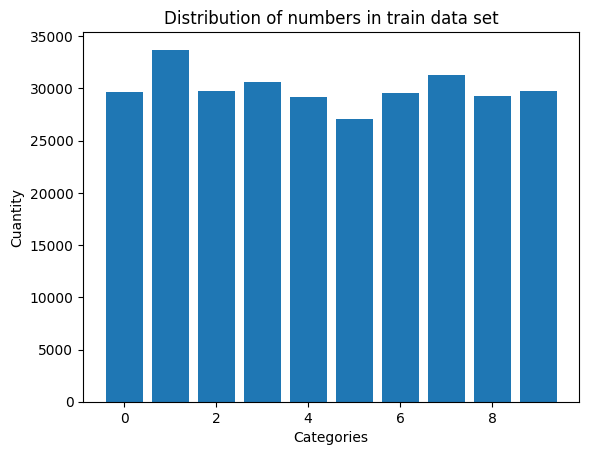

In [ ]:
train_x_values = list(distribution["train"].keys())
train_y_values_count = list(distribution["train"].values())

plt.bar(train_x_values, train_y_values_count)
plt.xlabel('Categories')
plt.ylabel('Cuantity')
plt.title('Distribution of numbers in train data set')
plt.show()

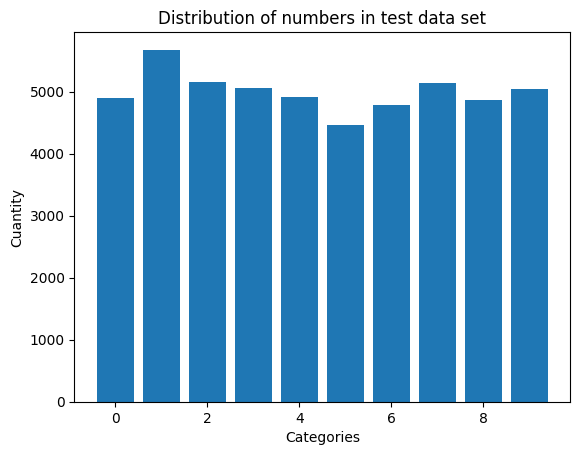

In [ ]:
test_x_values = list(distribution["test"].keys())
test_y_values_count = list(distribution["test"].values())

plt.bar(test_x_values, test_y_values_count)
plt.xlabel('Categories')
plt.ylabel('Cuantity')
plt.title('Distribution of numbers in test data set')
plt.show()

Como se puede ver la clase que tiene más valores es la del número 1 y la que tiene menos es el 5. Tanto los números en el test y train parecen tener la misma distribución de datos. Ahora bien, podríamos hacer un downsampling para que los datos estén completamente balanceados con la clase de menor cantidad, pero viendo las gráficas nos parece que realmente la data esta bastante bien balanceada. Y ya que realmente tenemos una gran cantidad de datos de todos los números no es necesario hacer cambios con respecto al balance o la cantidad de valores en testing y training. Con esto tenemos los datos listos para realizarlo los modelos.